In [49]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybedtools as pbt
import math
import pyranges as pr

In [50]:
wd = "/Genomics/kocherlab/bjarnold/Nmel"
macs_peaks_file = f"{wd}/MACS2/Nmel-F1_peaks.narrowPeak" 
# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

genrich_peaks_file = f"{wd}/genrich_single/Nmel-F1_peaks.narrowPeak"
# 1. chromosome
# 2. chromStart
# 3. chromEnd
# 4. name
# 5. score
# 6. strand
# 7. signalValue - total area under the curve (AUC)
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - summit position (0-based offset from chromStart)

genrich_pileup_file = f"{wd}/genrich_single/Nmel-F1_pileups.txt"

stpeaker_peaks_file = f"{wd}/starrpeaker_test/chr1/Nmel-F1.peak.final.bed"
# Column 1: Chromosome
# Column 2: Start position
# Column 3: End position
# Column 4: Name (peak rank based on score, 1 being the highest rank)
# Column 5: Score (integer value of "100 * fold change", maxed at 1000 per BED format specification)
# Column 6: Strand
# Column 7: Log2 Fold change (normalized output/input ratio, in log2 space)
# Column 8: Input fragment coverage (total fragments across/within replicate(s))
# Column 9: Output fragment coverage (total fragments across/within replicate(s))
# Column 10: -log10 of P-value
# Column 11: -log10 of Q-value (Benjamini-Hochberg False Discovery Rate, FDR)
stpeaker_raw_file = f"{wd}/starrpeaker_test/chr1/Nmel-F1.peak.bed"


From the Genrich [github repo](https://github.com/jsh58/Genrich#controlbackground-pileup-calculation):
The background pileup value is calculated by dividing the total sequence information (sum of read/fragment/interval lengths) in the experimental sample by the calculated genome length. The net control pileup value at a particular genomic position is the maximum of the background pileup value and the pileup of the control sample at that position (if a control sample is specified). Note that control pileups are scaled to match the experimental, based on the total sequence information in each.

Because the control pileup never dips below the background pileup, MACS could be calculating a fold diff that looks very different from the Genrich pileup data, in which local depth pileup that MACS is using is actually quite low but Genrich is using the background pileup value. This is why the MACS fold diff is so high.

As a control, MACS2 [fits a poisson](https://hbctraining.github.io/Intro-to-ChIPseq/lessons/05_peak_calling_macs.html#:~:text=about%20computing%20it.-,Peak%20detection,-After%20MACS%20shifts) to the surrounding 1kb, 5kb, 10kb, and also has a background poisson rate from entire genome. The maximum of these is used as the background rate. 

There may also be a discrepancy between MACS and Genrich results due to the fact that Genrich used a MQ cutoff whereas MACS did not.

In [51]:
pileup = []
with open(genrich_pileup_file, 'r') as f:
    for line in f:
        if line.startswith("NMEL_chr_1\t"):
            line = line.strip().split("\t")
            pileup.append(line)

pileup_df = pd.DataFrame(pileup)
pileup_df.columns = ["chr", "start", "end", "experimental", "control", "-log(p)"]
# change experimental, control, and -log(p) columns to numeric
pileup_df[['start', 'end', 'experimental', 'control', '-log(p)']] = pileup_df[['start', 'end', 'experimental', 'control', '-log(p)']].apply(pd.to_numeric)

pileup_df['bases'] = pileup_df['end'] - pileup_df['start']
pileup_df['experimental_perbase'] = pileup_df['experimental']*pileup_df['bases']
pileup_df['control_perbase'] = pileup_df['control']*pileup_df['bases']

pileup_df['fold_diff'] = pileup_df['experimental']/pileup_df['control']
pileup_df['midpoint'] = (pileup_df['end'] - pileup_df['start'])/2 + pileup_df['start']
pileup_df.chr.unique()


array(['NMEL_chr_1'], dtype=object)

In [52]:
pileup_df[['experimental_perbase', 'control_perbase']].mean()

experimental_perbase    1177.238929
control_perbase         1447.287709
dtype: float64

In [53]:
macs_df = pd.read_csv(macs_peaks_file, sep="\t", header=None)
macs_df.columns = ["chromosome", "start", "end", "name_m", "score_m", "strand_m", "signalValue_m", "pValue_m", "qValue_m", "peak_m"]
macs_df = macs_df.sort_values(by=["chromosome","start"])
macs_df["peak_coord_m"] = macs_df["peak_m"] + macs_df["start"]

genrich_df = pd.read_csv(genrich_peaks_file, sep="\t", header=None)
genrich_df.columns = ["chromosome", "start", "end", "name_g", "score_g", "strand_g", "signalValue_g", "pValue_g", "qValue_g", "peak_g"]
genrich_df = genrich_df.sort_values(by=["chromosome","start"])
genrich_df["peak_coord_g"] = genrich_df["peak_g"] + genrich_df["start"]

stpeaker_df = pd.read_csv(stpeaker_peaks_file, sep="\t", header=None)
stpeaker_df.columns = ["chromosome", "start", "end", "name_s", "score_s", "strand_s", "log2FC_s", "input_s", "output_s", "pValue_s", "qValue_s"]
stpeaker_df['fold_change'] = 2**stpeaker_df['log2FC_s']
stpeaker_df['midpoint'] = (stpeaker_df['end'] - stpeaker_df['start']) + stpeaker_df['start']

stpeaker_raw_df = pd.read_csv(stpeaker_raw_file, sep="\t", header=None)
stpeaker_raw_df['midpoint'] = (stpeaker_raw_df[2] - stpeaker_raw_df[1]) + stpeaker_raw_df[1]
# sns.histplot(genrich_df["signalValue_g"].head(1000), color="blue", )
# plt.axvline(x=400)

In [54]:
# FILTER FOR CHROMOSOME 1
macs_df = macs_df[macs_df["chromosome"] == "NMEL_chr_1"]
genrich_df = genrich_df[genrich_df["chromosome"] == "NMEL_chr_1"]
stpeaker_df = stpeaker_df[stpeaker_df["chromosome"] == "NMEL_chr_1"]
pileup_df = pileup_df[pileup_df["chr"] == "NMEL_chr_1"]

4403 860


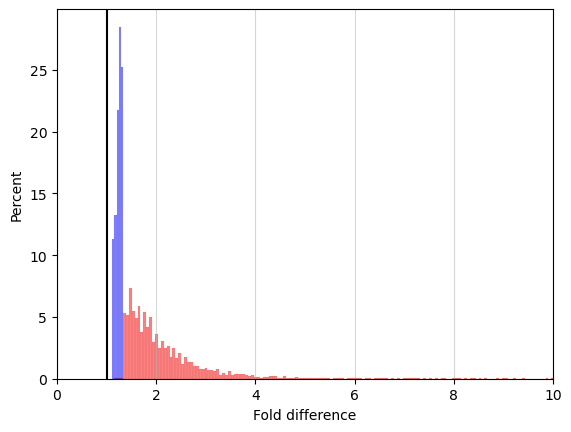

In [55]:
a = macs_df['signalValue_m'][macs_df['qValue_m'] > 1.3]
b = macs_df['signalValue_m'][macs_df['qValue_m'] <= 1.3]
sns.histplot(a, color="red", alpha=0.5, stat='percent', bins=1000)
sns.histplot(b, color="blue", alpha=0.5, stat='percent', bins=5)
plt.xlim(0,10)
plt.axvline(x=1, color="black")
plt.xlabel("Fold difference")
plt.grid(axis='x', alpha=0.5)
print(len(a), len(b))

In [56]:
# log_qval = 6 # 1.3 corresponds to qvalue of 0.05
macs_df = macs_df[macs_df["qValue_m"] > 1] # 1.3 corresponds to pvalue of 0.05
# macs_df = macs_df[macs_df["signalValue_m"] > 2] 
print(len(macs_df))

genrich_df = genrich_df[genrich_df["qValue_g"] > 1] # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
# genrich_df = genrich_df[genrich_df["signalValue_g"] > 200]
print(len(genrich_df))

stpeaker_df = stpeaker_df[stpeaker_df["qValue_s"] > 1.3] # 1.3 corresponds to pvalue of 0.05
print(len(stpeaker_df))



4571
2166
186


In [57]:
30000/300000000
1/0.0001



10000.0

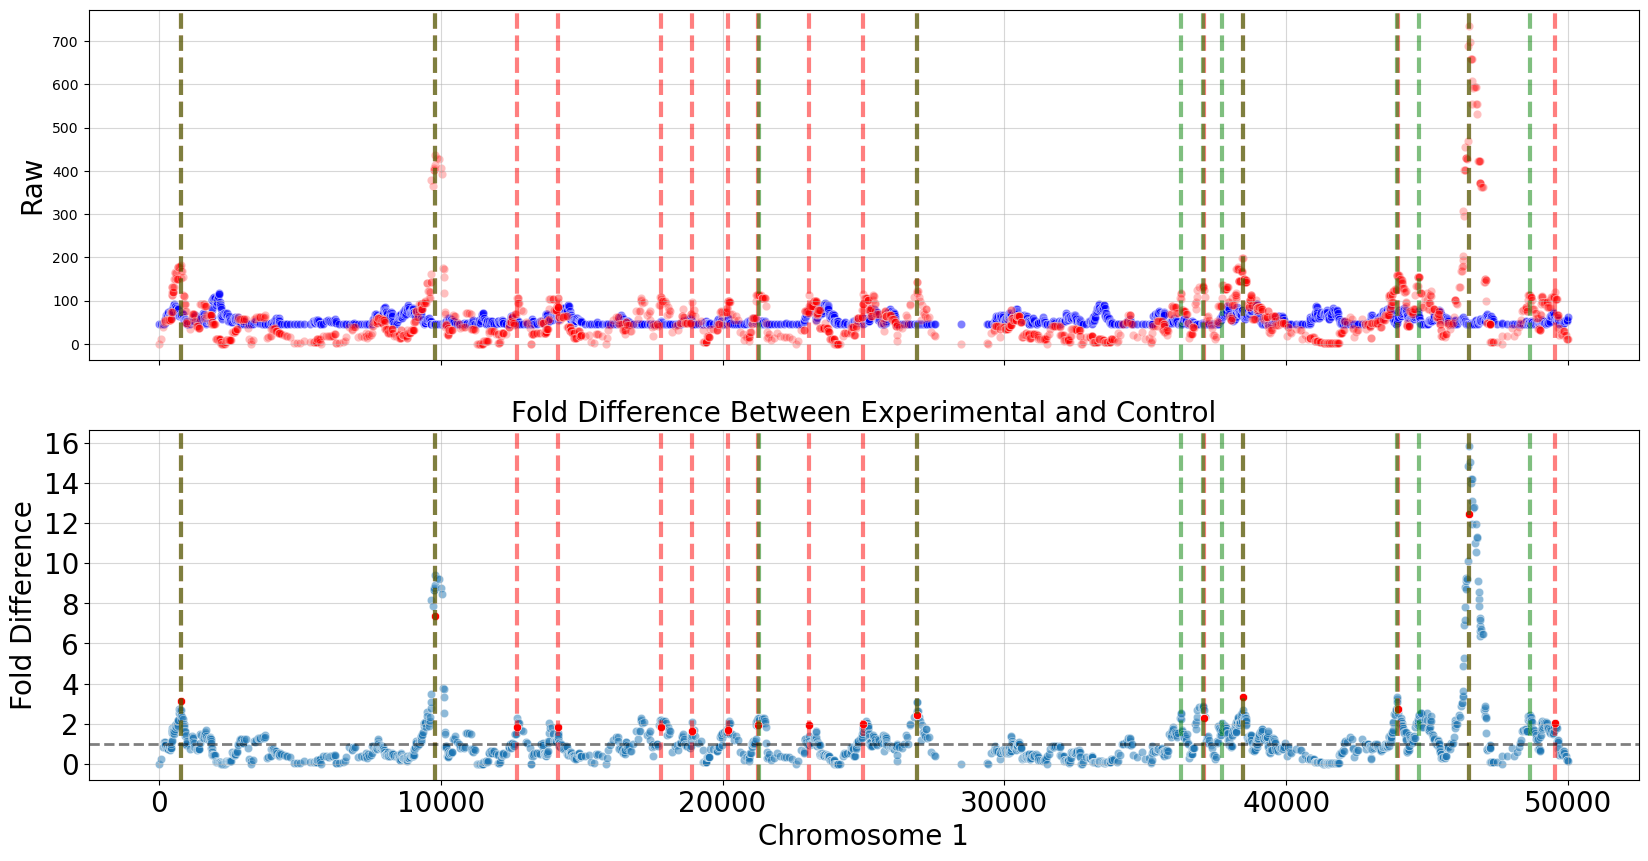

In [58]:
lowerb = 0
upperb = 50000

pileup_subset = pileup_df[(pileup_df['midpoint'] > lowerb) &( pileup_df['midpoint'] < upperb)]
macs_subset = macs_df[(macs_df['peak_coord_m'] > lowerb) &( macs_df['peak_coord_m'] < upperb)]
genrich_subset = genrich_df[(genrich_df['peak_coord_g'] > lowerb) &( genrich_df['peak_coord_g'] < upperb)]
stpeaker_subset = stpeaker_df[(stpeaker_df['midpoint'] > lowerb) &( stpeaker_df['midpoint'] < upperb)]
stpeaker_raw_subset = stpeaker_raw_df[(stpeaker_raw_df['midpoint'] > lowerb) &( stpeaker_raw_df['midpoint'] < upperb)]


fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
# plot raw experimental and control data
sns.scatterplot(data=pileup_subset, x="midpoint", y="control", alpha=0.5, color="blue",
                               ax=axs[0])
sns.scatterplot(data=pileup_subset, x="midpoint", y="experimental", alpha=0.25, color="red",
                               ax=axs[0])
# plot pileup fold difference
sns.scatterplot(data=pileup_subset, x="midpoint", y="fold_diff", alpha=0.5,
                               ax=axs[1])
#plot MACS2 fold difference
sns.scatterplot(data=macs_subset, x="peak_coord_m", y="signalValue_m", 
                               ax=axs[1], color='red')

# make verrtical lines for peaks according to macs_df['peak_coord_m'] coordinates
for i in macs_subset['peak_coord_m']:
    axs[0].axvline(x=i, color='red', linestyle='--', alpha=0.5, linewidth=3)
    axs[1].axvline(x=i, color='red', linestyle='--', alpha=0.5, linewidth=3)
for i in genrich_subset['peak_coord_g']:
    axs[0].axvline(x=i, color='green', linestyle='--', alpha=0.5, linewidth=3)
    axs[1].axvline(x=i, color='green', linestyle='--', alpha=0.5, linewidth=3)
# for i in stpeaker_subset['midpoint']:
#     axs[0].axvline(x=i, color='black', linestyle='-', alpha=0.5, linewidth=2)
#     axs[1].axvline(x=i, color='black', linestyle='-', alpha=0.5, linewidth=2)
    
axs[1].axhline(y=1, color='black', linestyle='--', alpha=0.5, linewidth=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Chromosome 1", fontsize=20)
axs[0].set_ylabel("Raw", fontsize=20)
axs[1].set_ylabel("Fold Difference", fontsize=20)
plt.title("Fold Difference Between Experimental and Control", fontsize=20)
# make grid lines with transparency
axs[0].grid(True, alpha=0.5)
axs[1].grid(True, alpha=0.5)



1.15272 59.9121


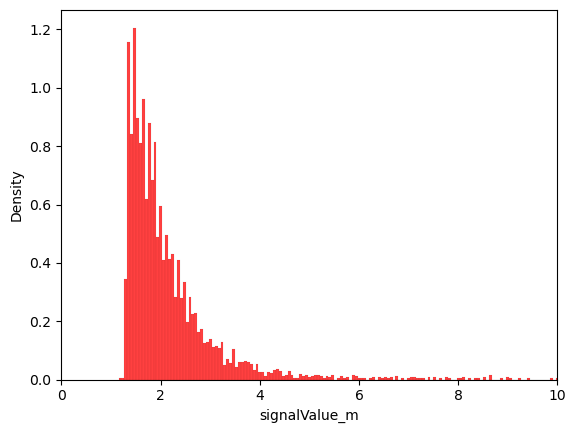

In [59]:
sns.histplot(macs_df["signalValue_m"], color="red", bins=1000, stat='density')
plt.xlim(0, 10)
print(min(macs_df["signalValue_m"]), max(macs_df["signalValue_m"]))

Text(0.5, 0, 'Peak Width')

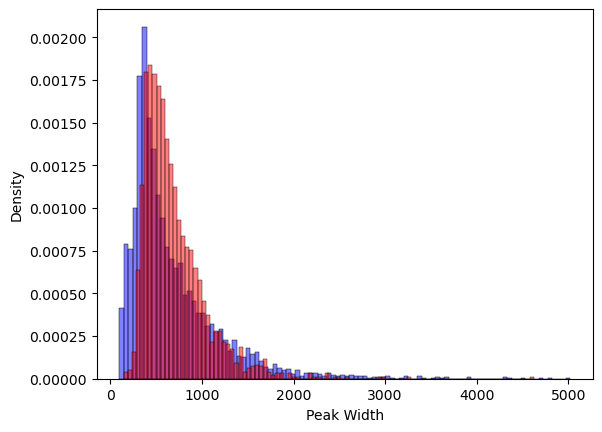

In [60]:
sns.histplot(macs_df['end']-macs_df['start'], bins=100, color="blue", alpha=0.5, stat='density')
sns.histplot(genrich_df['end']-genrich_df['start'], bins=100, color="red", alpha=0.5, stat='density')
plt.xlabel("Peak Width")

In [61]:
tmp = pd.merge(genrich_df, macs_df, on=["chromosome", "start"], how="inner", indicator=True)
print(len(genrich_df), len(macs_df), len(tmp))
# tmp
tmp = tmp[["chromosome", "start", "end_x", "end_y", "signalValue_m", "qValue_m", "signalValue_g", 'qValue_g']]
tmp

2166 4571 1129


,chromosome,start,end_x,end_y,signalValue_m,qValue_m,signalValue_g,qValue_g
0,NMEL_chr_1,464,963,1856,3.10966,33.19100,668.323669,2.387169
1,NMEL_chr_1,21190,21538,21538,1.91044,7.73906,296.311218,1.004378
2,NMEL_chr_1,26482,27367,27230,2.45093,17.18910,482.490051,1.819621
3,NMEL_chr_1,35789,36503,37123,2.26514,13.83430,182.803757,1.208686
4,NMEL_chr_1,37568,37953,39340,3.32765,39.27490,235.000687,1.132345
...,...,...,...,...,...,...,...,...
1124,NMEL_chr_1,14115298,14115734,14115734,3.19411,35.19350,985.135925,2.877994
1125,NMEL_chr_1,14116540,14116788,14117694,1.94422,8.02509,188.979584,1.117180
1126,NMEL_chr_1,14146082,14146384,14146384,2.33270,14.92380,286.577454,1.639802
1127,NMEL_chr_1,14163813,14164464,14164464,2.07935,10.45990,530.096130,1.301227


In [62]:
genrich_df

,chromosome,start,end,name_g,score_g,strand_g,signalValue_g,pValue_g,qValue_g,peak_g,peak_coord_g
125827,NMEL_chr_1,464,963,peak_125827,1000,.,668.323669,4.247956,2.387169,314,778
125830,NMEL_chr_1,9297,10150,peak_125830,1000,.,3491.588135,10.706824,8.108179,501,9798
125839,NMEL_chr_1,21190,21538,peak_125839,851,.,296.311218,2.358975,1.004378,87,21277
125842,NMEL_chr_1,26482,27367,peak_125842,545,.,482.490051,3.512384,1.819621,427,26909
125843,NMEL_chr_1,35789,36503,peak_125843,256,.,182.803757,2.664666,1.208686,474,36263
...,...,...,...,...,...,...,...,...,...,...,...
132217,NMEL_chr_1,14197192,14198223,peak_132217,1000,.,1435.234985,6.411541,4.199938,697,14197889
132220,NMEL_chr_1,14201579,14202040,peak_132220,786,.,362.374939,5.942694,3.793808,194,14201773
132221,NMEL_chr_1,14202331,14202711,peak_132221,1000,.,902.440063,8.870183,6.410994,208,14202539
132222,NMEL_chr_1,14205074,14205801,peak_132222,1000,.,13096.028320,54.138058,49.910698,287,14205361


In [63]:
m = pr.PyRanges(chromosomes=macs_df.chromosome,
                starts=macs_df.peak_coord_m - 100,
                ends=macs_df.peak_coord_m + 100)
g = pr.PyRanges(chromosomes=genrich_df.chromosome,
                starts=genrich_df.peak_coord_g - 100,
                ends=genrich_df.peak_coord_g + 100)

o = m.intersect(g)

In [64]:
print(len(m), len(g), len(o))
print()


4571 2166 1897



In [65]:
# for each peak_coord_m in macs_df['peak_coord_m'], 
# find the row in pileup_df in which the start and end coordinates in pileup_df contain the peak_coord_m in macs_df
# then take the fold_diff value from the pileup_df row and add it to a new column in macs_df

genrich_fold_diff = []
macs_fold_diff = []
for i,r in macs_df.iterrows():
    coord = r['peak_coord_m']
    pileup_row = pileup_df[(pileup_df['start'] <= coord) & (pileup_df['end'] > coord)]
    
    if len(pileup_row) == 1:
        genrich_fold_diff.append(pileup_row['fold_diff'].iloc[0])
        macs_fold_diff.append(r['signalValue_m'])
    else:
        print(len(pileup_row))

genrich_fold_diff = np.array(genrich_fold_diff)
macs_fold_diff = np.array(macs_fold_diff)
print(len(macs_df))
print(len(genrich_fold_diff))





4571
4571


[[1.        0.9535618]
 [0.9535618 1.       ]]
191
4380


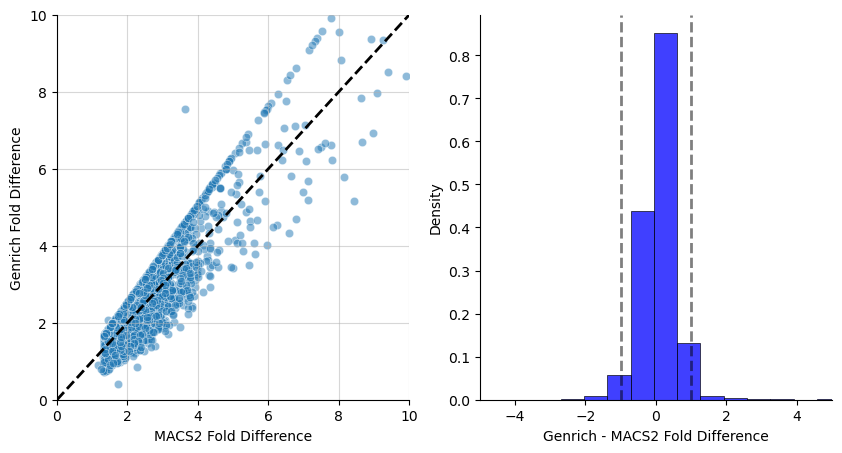

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=macs_fold_diff, y=genrich_fold_diff, alpha=0.5, ax=axs[0])
axs[0].set_xlabel("MACS2 Fold Difference", fontsize=10)
axs[0].set_ylabel("Genrich Fold Difference", fontsize=10)
axs[0].set_xlim(0,10)
axs[0].set_ylim(0,10)
# add diagonal line
axs[0].plot([0, 60], [0, 60], linewidth=2, color='black', linestyle='--')
# add grid lines
axs[0].grid(True, alpha=0.5)

sns.histplot(np.array(genrich_fold_diff)-np.array(macs_fold_diff), color="blue", bins=50, stat='density', ax=axs[1])
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Genrich - MACS2 Fold Difference", fontsize=10)
axs[1].axvline(x=1, color='black', linestyle='--', alpha=0.5, linewidth=2)
axs[1].axvline(x=-1, color='black', linestyle='--', alpha=0.5, linewidth=2)

sns.despine()   



print(np.corrcoef(genrich_fold_diff, macs_fold_diff))
print(sum(abs(genrich_fold_diff - macs_fold_diff) > 1))
print(sum(abs(genrich_fold_diff - macs_fold_diff) <= 1))

In [67]:
macs_df

,chromosome,start,end,name_m,score_m,strand_m,signalValue_m,pValue_m,qValue_m,peak_m,peak_coord_m
0,NMEL_chr_1,464,1856,MACS2/Nmel-F1_peak_1,331,.,3.10966,35.10910,33.19100,316,780
1,NMEL_chr_1,9111,10454,MACS2/Nmel-F1_peak_2,1957,.,7.38294,198.39800,195.74800,687,9798
3,NMEL_chr_1,12633,12979,MACS2/Nmel-F1_peak_4,63,.,1.82599,7.62602,6.38380,89,12722
4,NMEL_chr_1,13833,14180,MACS2/Nmel-F1_peak_5,63,.,1.82599,7.62602,6.38380,321,14154
5,NMEL_chr_1,16903,18150,MACS2/Nmel-F1_peak_6,66,.,1.84288,7.90240,6.64845,907,17810
...,...,...,...,...,...,...,...,...,...,...,...
5258,NMEL_chr_1,14208458,14208957,MACS2/Nmel-F1_peak_5259,222,.,1.68912,23.93670,22.20240,178,14208636
5259,NMEL_chr_1,14209410,14209973,MACS2/Nmel-F1_peak_5260,191,.,1.65198,20.86460,19.19620,424,14209834
5260,NMEL_chr_1,14210899,14211282,MACS2/Nmel-F1_peak_5261,85,.,1.49663,9.89378,8.55966,179,14211078
5261,NMEL_chr_1,14211723,14212632,MACS2/Nmel-F1_peak_5262,3279,.,5.24032,330.79400,327.94500,475,14212198


In [68]:
pileup_df

,chr,start,end,experimental,control,-log(p),bases,experimental_perbase,control_perbase,fold_diff,midpoint
0,NMEL_chr_1,0,20,0.0,46.426441,0.000000,20,0.0,928.528820,0.000000,10.0
1,NMEL_chr_1,20,144,11.0,46.426441,0.000016,124,1364.0,5756.878684,0.236934,82.0
2,NMEL_chr_1,144,175,40.0,46.426441,0.221720,31,1240.0,1439.219671,0.861578,159.5
3,NMEL_chr_1,175,213,51.0,46.426441,0.483407,38,1938.0,1764.204758,1.098512,194.0
4,NMEL_chr_1,213,222,51.0,47.167023,0.462279,9,459.0,424.503207,1.081264,217.5
...,...,...,...,...,...,...,...,...,...,...,...
519931,NMEL_chr_1,14214621,14214623,21.0,53.905167,0.000946,2,42.0,107.810334,0.389573,14214622.0
519932,NMEL_chr_1,14214623,14214624,19.0,46.426441,0.003656,1,19.0,46.426441,0.409250,14214623.5
519933,NMEL_chr_1,14214624,14214665,18.0,46.426441,0.002365,41,738.0,1903.484081,0.387710,14214644.5
519934,NMEL_chr_1,14214665,14214890,17.0,46.426441,0.001458,225,3825.0,10445.949225,0.366171,14214777.5


In [69]:
m = pr.PyRanges(chromosomes=macs_df.chromosome,
                starts=macs_df.peak_coord_m - 10,
                ends=macs_df.peak_coord_m + 10)
p = pr.PyRanges(chromosomes=pileup_df.chr,
                starts=pileup_df.midpoint - 10,
                ends=pileup_df.midpoint + 10)

In [70]:
print(len(m), len(p), len(m.overlap(p)))

4571 519936 4458


In [71]:
m.overlap(p)

,Chromosome,Start,End
0,NMEL_chr_1,770,790
1,NMEL_chr_1,9788,9808
2,NMEL_chr_1,12712,12732
3,NMEL_chr_1,14144,14164
4,NMEL_chr_1,17800,17820
...,...,...,...
4453,NMEL_chr_1,14208626,14208646
4454,NMEL_chr_1,14209824,14209844
4455,NMEL_chr_1,14211068,14211088
4456,NMEL_chr_1,14212188,14212208


In [72]:
pileup_df

,chr,start,end,experimental,control,-log(p),bases,experimental_perbase,control_perbase,fold_diff,midpoint
0,NMEL_chr_1,0,20,0.0,46.426441,0.000000,20,0.0,928.528820,0.000000,10.0
1,NMEL_chr_1,20,144,11.0,46.426441,0.000016,124,1364.0,5756.878684,0.236934,82.0
2,NMEL_chr_1,144,175,40.0,46.426441,0.221720,31,1240.0,1439.219671,0.861578,159.5
3,NMEL_chr_1,175,213,51.0,46.426441,0.483407,38,1938.0,1764.204758,1.098512,194.0
4,NMEL_chr_1,213,222,51.0,47.167023,0.462279,9,459.0,424.503207,1.081264,217.5
...,...,...,...,...,...,...,...,...,...,...,...
519931,NMEL_chr_1,14214621,14214623,21.0,53.905167,0.000946,2,42.0,107.810334,0.389573,14214622.0
519932,NMEL_chr_1,14214623,14214624,19.0,46.426441,0.003656,1,19.0,46.426441,0.409250,14214623.5
519933,NMEL_chr_1,14214624,14214665,18.0,46.426441,0.002365,41,738.0,1903.484081,0.387710,14214644.5
519934,NMEL_chr_1,14214665,14214890,17.0,46.426441,0.001458,225,3825.0,10445.949225,0.366171,14214777.5
